In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
from enum import Enum
from collections import namedtuple
from collections import OrderedDict

import EESEnvelopePerformance as EES
from EESEnvelopePerformance import Direction
from EESEnvelopePerformance import Orientation
from EESEnvelopePerformance import simple_HouseType
from EESEnvelopePerformance import Region

# I 外皮性能の計算方法 (関数)

## 1) はじめに

本計算は第3章「暖冷房負荷と外皮性能」第2章「外皮性能」にもとづく。  
自立循環型住宅への設計プログラムにおいては、当面の間、簡易法のみの実装とする。  
自立循環型住宅への設計プログラムの簡易法において、以下の機能が追加される。  
* 主開口方位が任意に選択可能
* 開口部の仕様について、主開口方位の窓とその他の方位の窓と別々に入力可能である。
* 立地によって隣棟が日射の当たり方に及ぼす影響が変わり、方位係数が変化する。

## 2) 関数

### 方位係数(簡易)(自立)

省エネ基準では、主たる開口の方位は南西に固定されている。  
一方で、自立循環型住宅への設計プログラムでは、主たる開口の方位を指定できるようにする。

In [2]:
def get_JJJ_simple_Orientation_value_from_Direction(direction_value, main_direction):
    # direction_value: [(S,SW,W,NW,N,NE,E,SE,top,bottom)の辞書型]
    # main_direction: 主開口の方位[Direction型]
    
    if main_direction == Direction.S:
        ort = Orientation(Direction.S,  Direction.W,  Direction.N,  Direction.E  )
    elif main_direction == Direction.SW:
        ort = Orientation(Direction.SW, Direction.NW, Direction.NE, Direction.SE )
    elif main_direction == Direction.W:
        ort = Orientation(Direction.W,  Direction.N,  Direction.E,  Direction.S  )
    elif main_direction == Direction.NW:
        ort = Orientation(Direction.NW, Direction.NE, Direction.SE, Direction.SW )
    elif main_direction == Direction.N:
        ort = Orientation(Direction.N,  Direction.E,  Direction.S,  Direction.W  )
    elif main_direction == Direction.NE:
        ort = Orientation(Direction.NE, Direction.SE, Direction.SW, Direction.NW )
    elif main_direction == Direction.E:
        ort = Orientation(Direction.E,  Direction.S,  Direction.W,  Direction.N  )
    elif main_direction == Direction.SE:
        ort = Orientation(Direction.SE, Direction.SW, Direction.NW, Direction.NE )
    else:
        raise
    
    return Orientation(
        D0   = direction_value[ort.D0],
        D90  = direction_value[ort.D90],
        D180 = direction_value[ort.D180],
        D270 = direction_value[ort.D270])

### 方位係数

#### 定義

省エネ基準に定義される方位係数に（立地＝「NotConsidered」の場合以外）隣棟の影響による低減係数を乗じる。

In [3]:
def get_JJJ_nu_H(region,ricchi):
    # region: 地域の区分
    # Ricchi: 立地 [Ricchi列挙型 NotConsidered,KOUGAI,TOSHIBU,MISSHU_TOSHIBU]
    if ricchi == Ricchi.NotConsidered:
        return EES.get_nu_H(region)
    else:
        d = distance_rbc(ricchi)
        return { Direction.S      : EES.get_nu_H(region)[Direction.S]      * get_JJJ_distance_coefficient_degradation_H(d,Direction.S     ),
                 Direction.SW     : EES.get_nu_H(region)[Direction.SW]     * get_JJJ_distance_coefficient_degradation_H(d,Direction.SW    ),
                 Direction.W      : EES.get_nu_H(region)[Direction.W]      * get_JJJ_distance_coefficient_degradation_H(d,Direction.W     ),
                 Direction.NW     : EES.get_nu_H(region)[Direction.NW]     * get_JJJ_distance_coefficient_degradation_H(d,Direction.NW    ),
                 Direction.N      : EES.get_nu_H(region)[Direction.N]      * get_JJJ_distance_coefficient_degradation_H(d,Direction.N     ),
                 Direction.NE     : EES.get_nu_H(region)[Direction.NE]     * get_JJJ_distance_coefficient_degradation_H(d,Direction.NE    ),
                 Direction.E      : EES.get_nu_H(region)[Direction.E]      * get_JJJ_distance_coefficient_degradation_H(d,Direction.E     ),
                 Direction.SE     : EES.get_nu_H(region)[Direction.SE]     * get_JJJ_distance_coefficient_degradation_H(d,Direction.SE    ),
                 Direction.top    : EES.get_nu_H(region)[Direction.top]    * get_JJJ_distance_coefficient_degradation_H(d,Direction.top   ),
                 Direction.bottom : EES.get_nu_H(region)[Direction.bottom] * get_JJJ_distance_coefficient_degradation_H(d,Direction.bottom) }

In [4]:
def get_JJJ_nu_C(region,ricchi):
    # Ricchi: 立地 [Ricchi列挙型 NotConsidered,KOUGAI,TOSHIBU,MISSHU_TOSHIBU]
    if ricchi == Ricchi.NotConsidered:
        return EES.get_nu_C(region)
    else:
        d = distance_rbc(ricchi)
        return { Direction.S      : EES.get_nu_C(region)[Direction.S]      * get_JJJ_distance_coefficient_degradation_C(d,Direction.S     ),
                 Direction.SW     : EES.get_nu_C(region)[Direction.SW]     * get_JJJ_distance_coefficient_degradation_C(d,Direction.SW    ),
                 Direction.W      : EES.get_nu_C(region)[Direction.W]      * get_JJJ_distance_coefficient_degradation_C(d,Direction.W     ),
                 Direction.NW     : EES.get_nu_C(region)[Direction.NW]     * get_JJJ_distance_coefficient_degradation_C(d,Direction.NW    ),
                 Direction.N      : EES.get_nu_C(region)[Direction.N]      * get_JJJ_distance_coefficient_degradation_C(d,Direction.N     ),
                 Direction.NE     : EES.get_nu_C(region)[Direction.NE]     * get_JJJ_distance_coefficient_degradation_C(d,Direction.NE    ),
                 Direction.E      : EES.get_nu_C(region)[Direction.E]      * get_JJJ_distance_coefficient_degradation_C(d,Direction.E     ),
                 Direction.SE     : EES.get_nu_C(region)[Direction.SE]     * get_JJJ_distance_coefficient_degradation_C(d,Direction.SE    ),
                 Direction.top    : EES.get_nu_C(region)[Direction.top]    * get_JJJ_distance_coefficient_degradation_C(d,Direction.top   ),
                 Direction.bottom : EES.get_nu_C(region)[Direction.bottom] * get_JJJ_distance_coefficient_degradation_C(d,Direction.bottom) }

立地から隣棟距離を求める換算式。

In [5]:
def distance_rbc(ricchi):
    # Ricchi: 立地 [Ricchi列挙型 KOUGAI,TOSHIBU,MISSHU_TOSHIBU]
    return 67.10 * np.exp( -6.05 * get_rbc()[ricchi] )

立地は、「郊外」「都市部」「密集した都市部」の3パターン。

In [6]:
class Ricchi(Enum):
    NotConsidered = 0
    KOUGAI = 1
    TOSHIBU = 2
    MISSHU_TOSHIBU = 3

立地から区域建蔽率を決定する。

| 立地 | 区域建蔽率 |
| ---- | ---------- |
| 郊外 | 25% |
| 都市部 | 35% |
| 密集した都市部 | 50% |

In [15]:
def get_rbc():
    return { Ricchi.KOUGAI: 0.25, Ricchi.TOSHIBU: 0.35, Ricchi.MISSHU_TOSHIBU: 0.5 }

隣棟との距離から方位係数の低減率を計算する。

In [19]:
def get_JJJ_distance_coefficient_degradation_H( d, direction ):
    # d : 隣等距離(m)
    # direction : 方位[Direction型]

    def get_Coefficient_H():
        return { Direction.S  : (0.0436, 0.0000),
                 Direction.SW : (0.0368, 0.0156),
                 Direction.W  : (0.0295, 0.0528),
                 Direction.NW : (0.0286, 0.1035),
                 Direction.N  : (0.0297, 0.1168),
                 Direction.NE : (0.0284, 0.1055),
                 Direction.E  : (0.0302, 0.0490),
                 Direction.SE : (0.0361, 0.0138) }
    
    if direction == Direction.top:
        return 1.0
    elif direction == Direction.bottom:
        return 0.0
    else:
        a, b = get_Coefficient_H()[direction]
        return ( a * d ** 2 + b * d)/( a * d ** 2 + b * d + 1)

In [73]:
def get_JJJ_distance_coefficient_degradation_C( d, direction ):
    # d : 隣等距離(m)
    # direction : 方位[Direction型]
    def get_Coefficient_C():
        return { Direction.S  : (0.0307, 0.1933),
                 Direction.SW : (0.0464, 0.0583),
                 Direction.W  : (0.0255, 0.0747),
                 Direction.NW : (0.0249, 0.0947),
                 Direction.N  : (0.0153, 0.1371),
                 Direction.NE : (0.0250, 0.0972),
                 Direction.E  : (0.0259, 0.0773),
                 Direction.SE : (0.0456, 0.0625) }

    if direction == Direction.top:
        return 1.0
    elif direction == Direction.bottom:
        return 0.0
    else:
        a, b = get_Coefficient_C()[direction]
        return ( a * d ** 2 + b * d)/( a * d ** 2 + b * d + 1)

#### 説明

暖房期

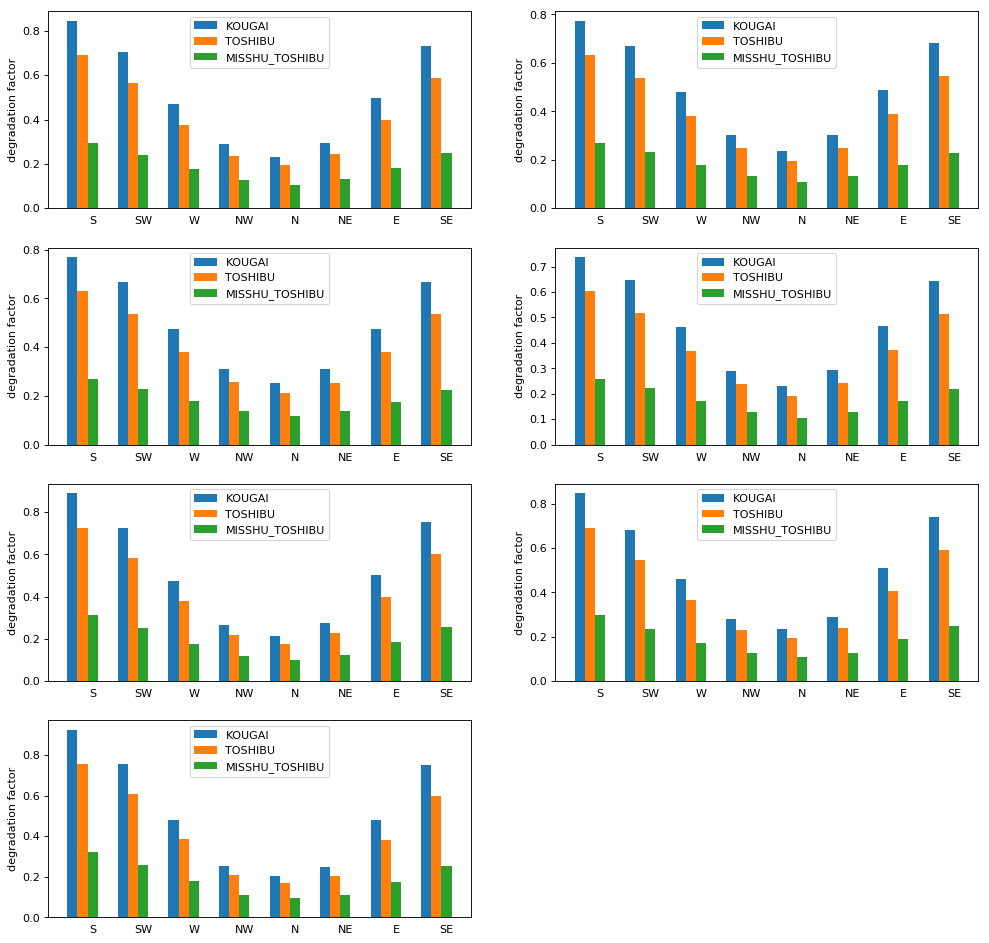

In [76]:
plt.figure(figsize=(15,15),dpi=80)

Regions = [Region.Division1,Region.Division2,Region.Division3,Region.Division4,Region.Division5,Region.Division6,Region.Division7]

directions = [Direction.N,Direction.NE,Direction.E,Direction.SE,Direction.S,Direction.SW,Direction.W,Direction.NW]

for i, region in enumerate(Regions):
    ax = plt.subplot(4, 2, i+1)
    ax.set_ylabel("degradation factor")
    for j, ricchi in enumerate([Ricchi.KOUGAI,Ricchi.TOSHIBU,Ricchi.MISSHU_TOSHIBU]):
        x = [direction.value + j*0.2 for direction in directions]
        y = [get_JJJ_nu_H(region,ricchi)[direction] for direction in directions]
        label = [direction.name for direction in directions]
        ax.bar(x,y,width = 0.2,tick_label=label,label=ricchi.name)
    ax.tick_params(axis = 'x', bottom = 'off')
    ax.legend()
plt.show()

冷房期

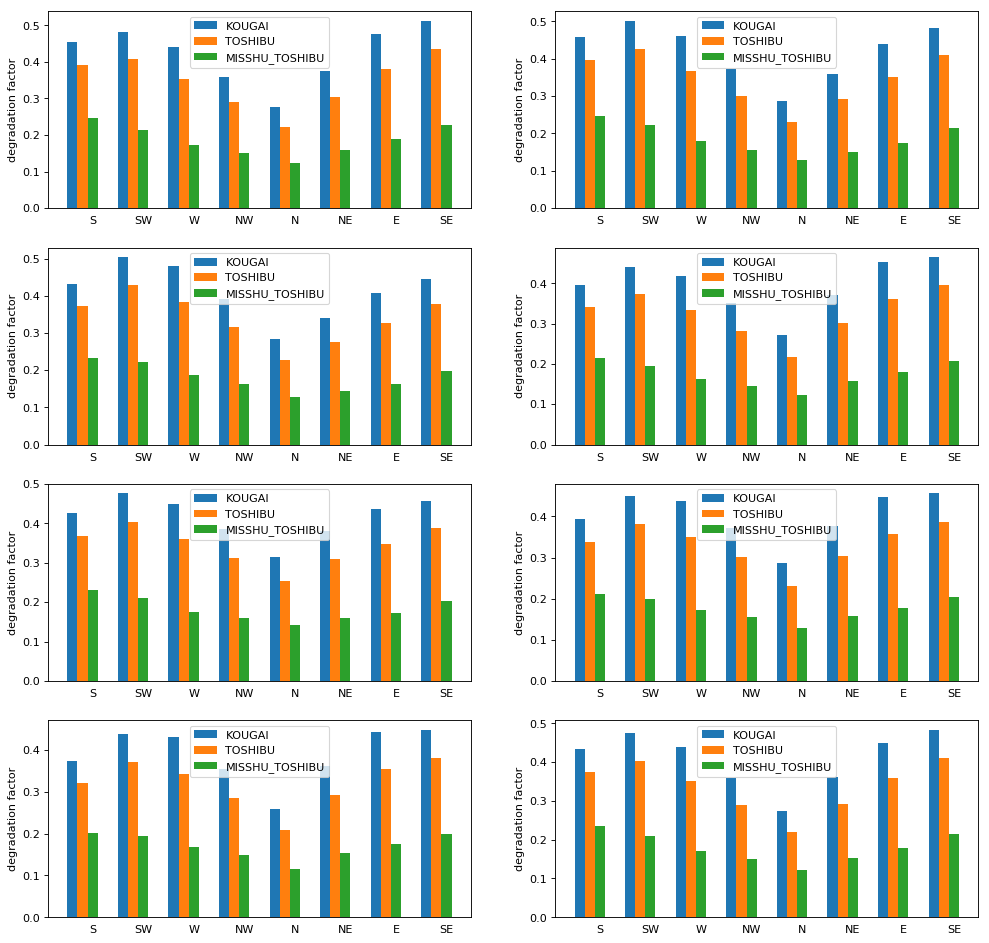

In [75]:
plt.figure(figsize=(15,15),dpi=80)

Regions = [Region.Division1,Region.Division2,Region.Division3,Region.Division4,Region.Division5,Region.Division6,Region.Division7,Region.Division8]

directions = [Direction.N,Direction.NE,Direction.E,Direction.SE,Direction.S,Direction.SW,Direction.W,Direction.NW]

for i, region in enumerate(Regions):
    ax = plt.subplot(4, 2, i+1)
    ax.set_ylabel("degradation factor")
    for j, ricchi in enumerate([Ricchi.KOUGAI,Ricchi.TOSHIBU,Ricchi.MISSHU_TOSHIBU]):
        x = [direction.value + j*0.2 for direction in directions]
        y = [get_JJJ_nu_C(region,ricchi)[direction] for direction in directions]
        label = [direction.name for direction in directions]
        ax.bar(x,y,width = 0.2,tick_label=label,label=ricchi.name)
    ax.tick_params(axis = 'x', bottom = 'off')
    ax.legend()

plt.show()

# II 外皮性能の計算方法 (統合)

## 1-1) 外皮の部位

外皮の部位は、外壁(界壁)・天井・屋根・床(界床)から成る一般部位と、開口部（窓・ドア）、土間床で構成される。また、熱の計算においては、外皮の部位を面的に流れる熱流に加え、RC造やS造の隅角部等における熱橋計算および土間床外周部の熱計算を行う必要がある。  
* 熱損失が面積あたりで定義される部位：「一般部位」「開口部(窓)」「開口部(ドア)」  
* 熱損失が長さあたりで定義される部位：「熱橋」「土間床外周部」

## 2) 関数の統合

### 簡易法(自立)

#### 定義

In [79]:
def get_JJJsimpleEnvPerformance_Selected(house_type, region, ricchi, main_direction,
                                 U_roof, U_wall, U_door, U_wnd, U_floor, psi_prm,
                                 eta_d_H, eta_d_C, default_f_H, default_f_C):
    # house_type: 住宅の種類(床断熱住宅・基礎断熱住宅・床断熱基礎断熱併用住宅)
    # region: 地域の区分
    # ricchi: 立地 {Ricchi列挙体}
    # main_direction: 主たる開口の方位
    # U_roof, U_wall, U_door, U_wnd, U_floor: 熱損失係数(W/m2K)(屋根・外壁・ドア・窓・床)
    # psi_prm: 線熱損失係数(W/mK)(土間床外周部)
    # eta_d_H, eta_d_C: 窓のηd値(暖房期・冷房期)(-)
    # default_f_H, default_f_C; f値としてデフォルト値を使用する場合のf値(暖房期・冷房期)(-)

    results = OrderedDict()
    
    # 基礎の熱損失は現時点で評価方法が存在しない(土間床外周部の熱損失に含まれている)ため、0.0とする。
    U_base   = 0.0
    U_base_d = 0.0
    
    # 玄関等の基礎については、デフォルト値として1.8を採用する。
    psi_prm_d = 1.8
    
    def get_U_A_provisional(house_type, U_roof, U_wall, U_door, U_wnd, U_floor, U_base, U_base_d, psi_prm, psi_prm_d):
        al = EES.simple_Area_and_Length(house_type)
        return EES.get_simple_U_A (al.roof, al.wall, al.door, al.wnd, al.floor, al.base, al.base_IS, al.base_d, al.base_d_IS, al.prm, al.prm_IS, al.prm_d, al.prm_d_IS,
                                   EES.simple_HValue.roof, EES.simple_HValue.wall, EES.simple_HValue.door, EES.simple_HValue.wnd, EES.simple_HValue.floor, EES.simple_HValue.base_OS, EES.simple_HValue.base_IS, EES.simple_HValue.prm_OS, EES.simple_HValue.prm_IS,
                                   U_roof, U_wall, U_door, U_wnd, U_floor, U_base, U_base_d, psi_prm, psi_prm_d,
                                   al.env )
    
    U_A_floor_ins = get_U_A_provisional(EES.simple_HouseType.floor_ins,U_roof, U_wall, U_door, U_wnd, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    U_A_base_ins  = get_U_A_provisional(EES.simple_HouseType.base_ins ,U_roof, U_wall, U_door, U_wnd, U_floor, U_base, U_base_d, psi_prm, psi_prm_d)
    
    if house_type == EES.simple_HouseType.floor_ins:
        house_type_on_calc = house_type
        U_A = U_A_floor_ins
    elif house_type == EES.simple_HouseType.base_ins:
        house_type_on_calc = house_type
        U_A = U_A_base_ins
    else:
        U_A, house_type_on_calc = judge_simple_house_type(U_A_floor_ins, U_A_base_ins)
    
    results["Judged House Type"] = house_type_on_calc
    results["UA"] = U_A
    
    al = EES.simple_Area_and_Length(house_type_on_calc)

    eta_H_roof   = EES.get_simple_eta_H_roof(U_roof)
    eta_H_wall   = EES.get_simple_eta_H_wall(U_wall)
    eta_H_door   = EES.get_simple_eta_H_door(U_door)
    eta_H_base   = EES.get_simple_eta_H_base(U_base)
    eta_H_base_d = EES.get_simple_eta_H_base_d(U_base_d)
    eta_C_roof   = EES.get_simple_eta_C_roof(U_roof)
    eta_C_wall   = EES.get_simple_eta_C_wall(U_wall)
    eta_C_door   = EES.get_simple_eta_C_door(U_door)
    eta_C_base   = EES.get_simple_eta_C_base(U_base)
    eta_C_base_d = EES.get_simple_eta_C_base_d(U_base_d)

    # f値として、常にデフォルト値を使用するため、f_H,f_Cは使用されない。仮に0.0を代入する。
    f_H = 0.0
    f_C = 0.0
    is_f_value_default = True

    eta_H_wnd    = EES.get_simple_eta_H_window(eta_d_H, f_H, is_f_value_default, default_f_H)
    eta_C_wnd    = EES.get_simple_eta_C_window(eta_d_C, f_C, is_f_value_default, default_f_C)

    results["eta_H_wnd"]=eta_H_wnd
    results["eta_C_wnd"]=eta_C_wnd
    
    # nu_H = get_simple_Orientation_value_from_Direction(get_nu_H(region))
    # nu_C = get_simple_Orientation_value_from_Direction(get_nu_C(region))
    nu_H_top = get_JJJ_nu_H(region,ricchi)[Direction.top]
    nu_C_top = get_JJJ_nu_C(region,ricchi)[Direction.top]
    nu_H_horizontal = get_JJJ_simple_Orientation_value_from_Direction(get_JJJ_nu_H(region,ricchi), main_direction)
    nu_C_horizontal = get_JJJ_simple_Orientation_value_from_Direction(get_JJJ_nu_C(region,ricchi), main_direction)

    eta_A_H = EES.get_simple_eta_A_H(al.roof, al.wall, al.door, al.wnd, al.base, al.base_d,
                                     nu_H_top, nu_H_horizontal,
                                     eta_H_roof, eta_H_wall, eta_H_door, eta_H_wnd, eta_H_base, eta_H_base_d,
                                     al.env)
    eta_A_C = EES.get_simple_eta_A_C(al.roof, al.wall, al.door, al.wnd, al.base, al.base_d,
                                     nu_C_top, nu_C_horizontal,
                                     eta_C_roof, eta_C_wall, eta_C_door, eta_C_wnd, eta_C_base, eta_C_base_d,
                                     al.env)

    results["eta_A_H"] = eta_A_H
    results["eta_A_C"] = eta_A_C
    
    r_env = EES.get_r_env(al.env, al.A)

    Q_dash = EES.get_Q_dash( float(U_A), r_env )
    results["Q_dash"] = Q_dash
    
    Mu_H = EES.get_Mu_H(float(eta_A_H), r_env)
    Mu_C = EES.get_Mu_C(float(eta_A_C), r_env)
    results["Mu_H"] = Mu_H
    results["Mu_C"] = Mu_C
    return results

In [82]:
get_JJJsimpleEnvPerformance_Selected( house_type = simple_HouseType.base_ins,
                                      region = Region.Division6,
                                      ricchi = Ricchi.MISSHU_TOSHIBU,
                                      main_direction = Direction.SW,
                                      U_roof=0.240, U_wall=0.530, U_door=2.330, U_wnd=3.490, U_floor=0.480, psi_prm=1.8,
                                      eta_d_H = 0.510, eta_d_C = 0.510, 
                                      default_f_H = Orientation(0.654,0.595,0.589,0.674666667),
                                      default_f_C = Orientation(0.852,0.864,0.862,0.852))    

OrderedDict([('Judged House Type', <simple_HouseType.base_ins: 1>),
             ('UA', Decimal('0.94')),
             ('eta_H_wnd',
              Orientation(D0=0.33354, D90=0.30345, D180=0.30039, D270=0.34408000017)),
             ('eta_C_wnd',
              Orientation(D0=0.43452, D90=0.44064, D180=0.43962, D270=0.43452)),
             ('eta_A_H', Decimal('1.1')),
             ('eta_A_C', Decimal('1.4')),
             ('Q_dash', 2.8794288888888886),
             ('Mu_H', 0.033695444444444445),
             ('Mu_C', 0.0428851111111111)])